# Принятие решения в бизнесе

Провести обработку данных. Проверить гипотезы различий в средних чеках и среднем количестве заказов в группах А и Б. Проверить различие между отфильтрованными данными и сырыми.

In [124]:
# Импорт библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go
import json
import re
from scipy.stats import ttest_ind
import scipy.stats as stats
from scipy.stats import ttest_1samp
from math import factorial


In [125]:
pd.options.display.max_colwidth = 200

In [126]:
# Загрузка датафрейма

visitors = pd.read_csv("/datasets/visitors.csv")

orders = pd.read_csv("/datasets/orders.csv")

hypothesis = pd.read_csv("/datasets/hypothesis.csv")

Файл hypothesis.csv.
Hypothesis — краткое описание гипотезы;
Reach — охват пользователей по 10-балльной шкале;
Impact — влияние на пользователей по 10-балльной шкале;
Confidence — уверенность в гипотезе по 10-балльной шкале;
Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.
______________________________________________________________________________________________________________________

Файл orders.csv.
transactionId — идентификатор заказа;
visitorId — идентификатор пользователя, совершившего заказ;
date — дата, когда был совершён заказ;
revenue — выручка заказа;
group — группа A/B-теста, в которую попал заказ.
______________________________________________________________________________________________________________________

Файл visitors.csv. Скачать датасет
date — дата;
group — группа A/B-теста;
visitors — количество пользователей в указанную дату в указанной группе A/B-теста

In [127]:
visitors.head()
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [128]:
#Приведем дату к Datetime
visitors['date'] = pd.to_datetime(visitors['date'], format='%Y-%m-%d')
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [129]:
orders.head()
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [130]:
orders['date'] = pd.to_datetime(orders['date'], format='%Y-%m-%d')
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [131]:
hypothesis.head()
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [132]:
# поищем дубли
print(visitors.shape[0])
print(visitors.duplicated(subset=['date', 'group', 'visitors']).sum())

print(visitors[visitors.duplicated(subset=['date', 'group', 'visitors'], keep=False)]
      [['date', 'group', 'visitors']])
visitors = visitors.drop_duplicates(subset=['date', 'group', 'visitors'], keep='first')
display(visitors.shape[0])

62
0
Empty DataFrame
Columns: [date, group, visitors]
Index: []


62

In [133]:
print(orders.shape[0])
print(orders.duplicated(subset=['transactionId', 'visitorId', 'group']).sum())

print(orders[orders.duplicated(subset=['transactionId', 'visitorId', 'group'], keep=False)]
      [['transactionId', 'visitorId', 'group']])
orders = orders.drop_duplicates(subset=['transactionId', 'visitorId', 'group'], keep='first')
display(orders.shape[0])

1197
0
Empty DataFrame
Columns: [transactionId, visitorId, group]
Index: []


1197

In [134]:
duplicates = orders[orders.duplicated(subset=['visitorId'], keep=False)]
grouped_duplicates = duplicates.groupby('visitorId')['group'].unique().reset_index()
users_in_both_groups = grouped_duplicates[grouped_duplicates['group'].apply(lambda x: len(x) > 1)]
print(users_in_both_groups)
users_to_remove = users_in_both_groups['visitorId']
orders = orders[~orders['visitorId'].isin(users_to_remove)]

     visitorId   group
0      8300375  [B, A]
1    199603092  [A, B]
2    232979603  [B, A]
3    237748145  [B, A]
5    276558944  [B, A]
6    351125977  [B, A]
8    393266494  [A, B]
10   457167155  [B, A]
11   471551937  [A, B]
12   477780734  [A, B]
17   818047933  [A, B]
18   963407295  [B, A]
19  1230306981  [A, B]
20  1294878855  [B, A]
21  1316129916  [A, B]
22  1333886533  [A, B]
24  1404934699  [B, A]
25  1602967004  [B, A]
26  1614305549  [B, A]
29  1648269707  [B, A]
30  1668030113  [B, A]
31  1738359350  [A, B]
33  1801183820  [B, A]
34  1959144690  [A, B]
37  2038680547  [B, A]
38  2044997962  [A, B]
44  2378935119  [A, B]
46  2458001652  [A, B]
47  2579882178  [A, B]
48  2587333274  [B, A]
49  2600415354  [B, A]
50  2654030115  [B, A]
51  2686716486  [A, B]
53  2712142231  [B, A]
54  2716752286  [B, A]
58  2780786433  [A, B]
60  2927087541  [A, B]
61  2949041841  [A, B]
62  2954449915  [A, B]
64  3062433592  [B, A]
66  3202540741  [A, B]
67  3234906277  [B, A]
72  3656415

In [135]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1016 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1016 non-null   int64         
 1   visitorId      1016 non-null   int64         
 2   date           1016 non-null   datetime64[ns]
 3   revenue        1016 non-null   int64         
 4   group          1016 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 47.6+ KB


Дубликатов невидно, проникновение пользователей одной группы в другую имеется, такие пользователи исключены из датафрема.

Выводы:
    Качество данных хорошее, дубликатов нет. Дату привел к правильному типу. 

# Часть 1. Приоритизация гипотез.

In [136]:
# Посчитаем ICE
hypothesis['ice']= (hypothesis['Impact']*hypothesis['Confidence'])/hypothesis['Efforts']
hypothesis['ice']=round(hypothesis['ice'], 2)
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts,ice
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20


In [137]:
# Посчитаем RICE
hypothesis['rice']= (hypothesis['Reach']*hypothesis['Impact']*hypothesis['Confidence'])/hypothesis['Efforts']

In [138]:
hypothesis_sort_ice = hypothesis.sort_values(by='ice', ascending=False)

In [139]:
hypothesis_sort_ice.head()

,Hypothesis,Reach,Impact,Confidence,Efforts,ice,rice
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,16.2
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,40.0
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,112.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00,40.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00,56.0


По параметру ICE топ-3 гипотезы ПОД НОМЕРАМИ 8, 0 И 7

In [140]:
hypothesis_sort_rice = hypothesis.sort_values(by='rice', ascending=False)
hypothesis_sort_rice.head()

,Hypothesis,Reach,Impact,Confidence,Efforts,ice,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,16.2


<div class="alert alert-warning">
    
**Комментарий ревьюера**

**#можно лучше**

Расчеты верны, но ice стоило отформатировать, сделать округление. Так лучше бы считывался результат
</div>

По параметру RICE топ-3 гипотезы ПОД НОМЕРАМИ 7, 2 и 0. Разница по отношению к ICE заключается в том, что RICE учитывает охват пользователей. Т.к. мы имеем дело с интернет магазином, гипотезы связаны с увеличением трафика интернет-магазина. Параметр RICH учитывает охват пользователей, поэтому на его стоит ориентироваться.

<div class="alert alert-danger">
    
**Комментарий ревьюера**

**#ошибка**

Давай в выводах поточнее напишем, на какой фреймворк стоит ориентироваться в нашем случае: интернет-магазин и гипотезы, которые предствлены. Как ты считаешь насколько важен показатель "охват", насколько он точно может быть оценен?
</div>

<div class="alert alert-success">
    
**Комментарий ревьюера - 2**

**#ок**

Хорошо. Действительно в реалиях интернет-магазина действительно охват можно достаточно достоверно оценить
</div>

# Часть 2. Анализ A/B-теста

In [141]:
#достаем уникальные значения дат и групп
datesGroups = orders[['date','group']].drop_duplicates().sort_values(by=['date', 'group'])

#выводим кумулятивные показатели из orders
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(x['date'] >= orders['date'], x['group']==orders['group'])]\
.agg({'date':'max', 'group':'max', 'transactionId':'nunique', 'visitorId':'nunique', 'revenue':'sum'}), axis = 1)
ordersAggregated.columns = ['date', 'group', 'orders', 'buyers', 'revenue']
#выводим кумулятивные показатели из visitors
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(x['date'] >= visitors['date'],
                                                                         x['group']==visitors['group'])]\
.agg({'date':'max', 'group':'max', 'visitors':'sum'}), axis = 1)
#сводим все накопительные данные в одну таблицу
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
print('\nПолученная таблица с кумулятивными (накопленными) значениями по дате и группам:'
'\n- кол-во покупок \n- кол-во покупателей \n- выручка \n- кол-во посетителей')
cumulativeData.head(5)


Полученная таблица с кумулятивными (накопленными) значениями по дате и группам:
- кол-во покупок 
- кол-во покупателей 
- выручка 
- кол-во посетителей


,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845


In [142]:
cumulativeDataA = cumulativeData[cumulativeData['group'] == 'A']
cumulativeDataB = cumulativeData[cumulativeData['group'] == 'B']

# Графики кумулятивной выручки по группам A/B

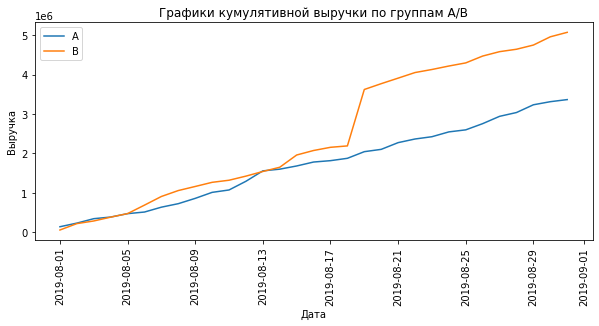

Выводы:
Как мы видим, группа B стабильно показывает большую выручку чем группа A. На графике группы В есть резкий всплеск.  Причиной всплеска является неоправданно высокая выручка.


In [143]:
plt.figure(figsize=(10,4))
plt.plot(cumulativeDataA['date'], cumulativeDataA['revenue'], label = 'A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['revenue'], label = 'B')
plt.ylabel('Выручка')
plt.xlabel('Дата')
plt.xticks(rotation=90)
plt.title('Графики кумулятивной выручки по группам A/B')
plt.legend()
plt.show()
print('Выводы:')
print('Как мы видим, группа B стабильно показывает большую выручку чем группа A. На графике группы В есть резкий всплеск.  Причиной всплеска является неоправданно высокая выручка.')

# График кумулятивного среднего чека по группам.

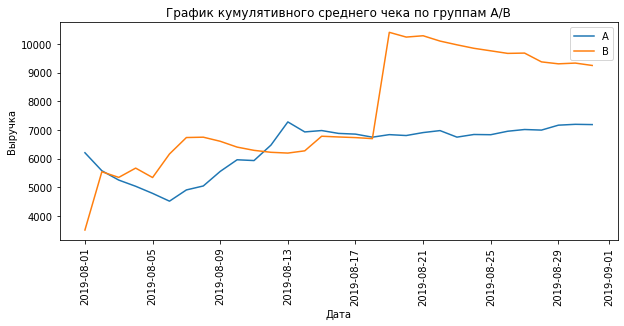

Выводы:
Как мы видим, группа B стабильно показывает больший средний чек чем группа A. На графике группы В есть резкий всплеск. Причиной всплеска является высокая выручка (крупный заказ). Иначе говоря - аномалия.


In [144]:
plt.figure(figsize=(10,4))
plt.plot(cumulativeDataA['date'], cumulativeDataA['revenue']/cumulativeDataA['orders'], label = 'A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['revenue']/cumulativeDataB['orders'], label = 'B')
plt.ylabel('Выручка')
plt.xlabel('Дата')
plt.xticks(rotation=90)
plt.title('График кумулятивного среднего чека по группам A/B')
plt.legend()
plt.show()
print('Выводы:')
print('Как мы видим, группа B стабильно показывает больший средний чек чем группа A. На графике группы В есть резкий всплеск. Причиной всплеска является высокая выручка (крупный заказ) или ошибка в значении (поставлен лишняя цифра в столбце выручка). Иначе говоря - аномалия.')

# график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A

In [145]:
#Объединим две полученные таблицы
mergedCumulativeConversion = cumulativeDataA.merge(cumulativeDataB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
mergedCumulativeConversion.head()

,date,groupA,ordersA,buyersA,revenueA,visitorsA,groupB,ordersB,buyersB,revenueB,visitorsB
0,2019-08-01,A,23,19,142779,719,B,17,17,59758,713
1,2019-08-02,A,42,36,234381,1338,B,40,39,221801,1294
2,2019-08-03,A,66,60,346854,1845,B,54,53,288850,1803
3,2019-08-04,A,77,71,388030,2562,B,68,66,385740,2573
4,2019-08-05,A,99,92,474413,3318,B,89,87,475648,3280


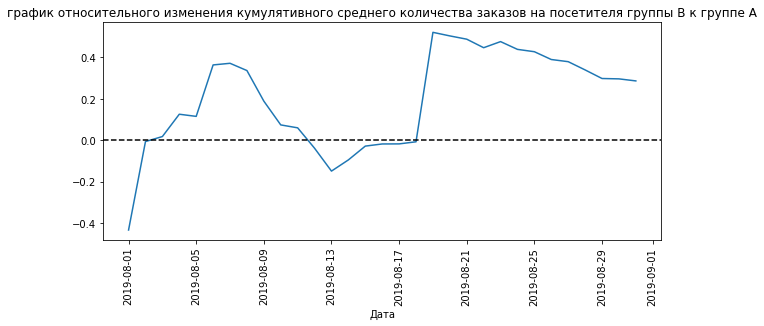

Опять после 17.08 имеется всплеск, что подтверждает теорию дорогой покупки.


In [146]:
plt.figure(figsize=(10,4))
plt.plot(mergedCumulativeConversion['date'], ((mergedCumulativeConversion['revenueB']/mergedCumulativeConversion['ordersB'])/
                                       (mergedCumulativeConversion['revenueA']/mergedCumulativeConversion['ordersA'])-1))
plt.axhline(y=0, color='black', linestyle = '--')
plt.title('график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A')
plt.xlabel('Дата')
plt.xticks(rotation=90)
plt.show()
print ('Опять после 17.08 имеется всплеск, что подтверждает теорию дорогой покупки.')

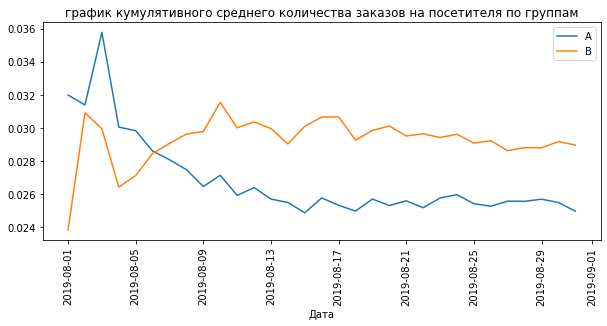

Средний чек группы В стабильно выше чем группы А


In [147]:
plt.figure(figsize=(10,4))
plt.plot(cumulativeDataA['date'], cumulativeDataA['orders']/cumulativeDataA['visitors'], label = 'A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['orders']/cumulativeDataB['visitors'], label = 'B')
plt.xticks(rotation=90)
plt.xlabel('Дата')
plt.title('график кумулятивного среднего количества заказов на посетителя по группам')
plt.legend()
plt.show()
print('Средний чек группы В стабильно выше чем группы А')

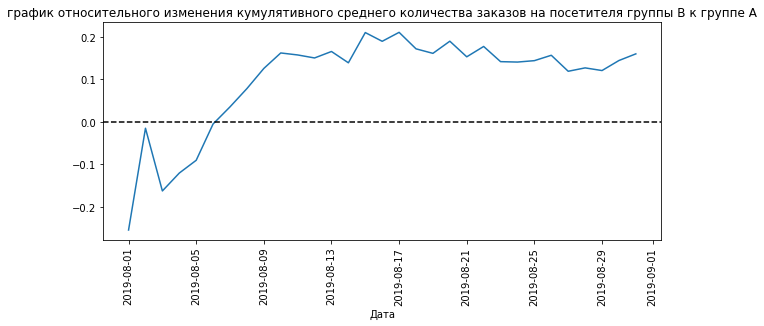

Спустя неделю от старта теста пользователи группы В конвертируются лучше пользователей группы А.


In [148]:
plt.figure(figsize=(10,4))
plt.plot(mergedCumulativeConversion['date'], ((mergedCumulativeConversion['ordersB']/mergedCumulativeConversion['visitorsB'])/
                                       (mergedCumulativeConversion['ordersA']/mergedCumulativeConversion['visitorsA'])-1))
plt.axhline(y=0, color='black', linestyle = '--')
plt.title('график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A')
plt.xlabel('Дата')
plt.xticks(rotation=90)
plt.show()
print('Спустя неделю от старта теста пользователи группы В конвертируются лучше пользователей группы А.')

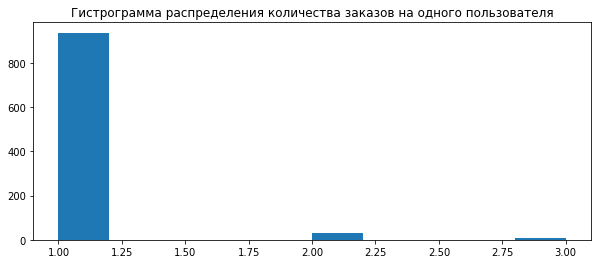

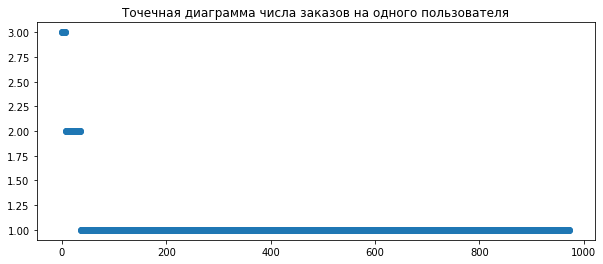

Выводы:
Судя по граифкам, подавляющее большинство пользователей не совершает более 2 заказов


In [149]:
orders.head(5)
ordersByUsers = orders.groupby('visitorId', as_index = False).agg({'transactionId':'nunique'}).sort_values(by='transactionId', ascending = False)
ordersByUsers.columns = ['visitorId', 'orders']
ordersByUsers.head(5)
plt.figure(figsize=(10,4))
plt.hist(ordersByUsers['orders'], bins = 10)
plt.title('Гистрограмма распределения количества заказов на одного пользователя')
plt.show()
x_values = pd.Series(range(0, len(ordersByUsers)))
plt.figure(figsize=(10,4))
plt.scatter(x_values, ordersByUsers['orders'])
plt.title('Точечная диаграмма числа заказов на одного пользователя')
plt.show()
print('Выводы:')
print('Судя по граифкам, подавляющее большинство пользователей не совершает более 2 заказов')

In [150]:
percentiles = np.percentile(ordersByUsers['orders'], [95, 99])
percentiles_orders = np.percentile(ordersByUsers['orders'], [95]).round(0)
print('Перцентили:\n95: {:.0f}\n99: {:.0f}'.format(percentiles[0],percentiles[1]))
percentiles_orders

Перцентили:
95: 1
99: 2


array([1.])

не более 5% потльзователей делают больше 2 заказов

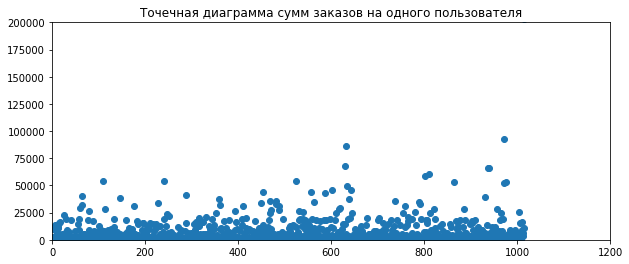

In [151]:
x_values = pd.Series(range(0, len(orders)))
plt.figure(figsize=(10,4))
plt.scatter(x_values, orders['revenue'])
plt.title('Точечная диаграмма сумм заказов на одного пользователя')
plt.axis([0, 1200, 0, 200000])
plt.show()

Количество заказов стоимостью более 25000 очень мало.

In [152]:
percentiles = np.percentile(orders['revenue'], [95, 99])
percentiles_revenue = np.percentile(orders['revenue'], [95]).round(0)
print('Перцентили:\n95: {:.0f}\n99: {:.0f}'.format(percentiles[0],percentiles[1]))
percentiles_revenue

Перцентили:
95: 26785
99: 53904


array([26785.])

Всего 5% заказов юольше 28 000

Выводы:
Всего 5% заказов больше 28 000 рублей
Не более 5% потльзователей делают больше 2 заказов

# Анализ А\Б теста

Нулевая гипотеза - различий нет, т.е. показатели группы А и В имеют статистически малое различие. Альтернативная - есть различия, т.е. показатели группы А и В имеют статистически большое различие.

# Не очиценные данные

In [153]:
ordersByUsersA = orders[orders['group']=='A'].groupby('visitorId', as_index=False).agg({'transactionId':'nunique'})
ordersByUsersA.columns = ['visitorId', 'orders']
ordersByUsersB = orders[orders['group']=='B'].groupby('visitorId', as_index=False).agg({'transactionId':'nunique'})
ordersByUsersB.columns = ['visitorId', 'orders']
print('Кол-во покупателей в группе A: {}'.format(len(ordersByUsersA)))
print('Кол-во покупок в группе А: {}'.format(ordersByUsersA['orders'].sum()))
print('Кол-во посетителей в группе A: {}\n'.format(visitors[visitors['group']=='A']['visitors'].sum()))
print('Кол-во покупателей в группе B: {}'.format(len(ordersByUsersB)))
print('Кол-во покупок в группе B: {}'.format(ordersByUsersB['orders'].sum()))
print('Кол-во посетителей в группе B: {}'.format(visitors[visitors['group']=='B']['visitors'].sum()))


#составим списки кол-ва заказов sampleA и sampleB со всеми пользователями (в том числе и не купившими) по группам 
list_orders_1 =[]
for i in range(0,(visitors[visitors['group']=='A']['visitors'].sum()-len(ordersByUsersA))):
    list_orders_1.append(0)
orders_by_non_purchased_users_A = pd.Series(data = list_orders_1, name = 'orders')

list_orders_2 =[]
for i in range(0,(visitors[visitors['group']=='B']['visitors'].sum()-len(ordersByUsersB))):
    list_orders_2.append(0)
orders_by_non_purchased_users_B = pd.Series(data = list_orders_2, name = 'orders')

sampleA = pd.concat([ordersByUsersA['orders'], orders_by_non_purchased_users_A], axis=0)
sampleB = pd.concat([ordersByUsersB['orders'], orders_by_non_purchased_users_B], axis=0)
print('\nОтносительный прирост конверсии группы B по отношению к группе A: {:.3f}'.format(sampleB.mean()/sampleA.mean()-1))
alpha = 0.05
results = stats.mannwhitneyu(sampleA, sampleB)
print('P-value: {}'.format(results.pvalue))
if results.pvalue < alpha:
    print('По неочищенным данным в конверсии групп A и B РАЗНИЦА СТАТИСТИЧЕСКИ ЗНАЧИМА!')
else:
    print('По неочищенным данным РАЗЛИЧИЙ в конверсии групп A и B НЕТ!')

Кол-во покупателей в группе A: 445
Кол-во покупок в группе А: 468
Кол-во посетителей в группе A: 18736

Кол-во покупателей в группе B: 528
Кол-во покупок в группе B: 548
Кол-во посетителей в группе B: 18916

Относительный прирост конверсии группы B по отношению к группе A: 0.160
P-value: 0.011018084110014696
По неочищенным данным в конверсии групп A и B РАЗНИЦА СТАТИСТИЧЕСКИ ЗНАЧИМА!


In [154]:
print('{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))
print('P-value: {}'.format(results.pvalue))
if results.pvalue < alpha:
    print('По неочищенным данным РАЗНИЦА в средних чеках в группах A и B СТАТИСТИЧЕСКИ ЗНАЧИМА!')
else:
    print('По неочищенным данным РАЗЛИЧИЙ в средних чеках в группах A и B НЕТ!')

0.829
0.287
P-value: 0.011018084110014696
По неочищенным данным РАЗНИЦА в средних чеках в группах A и B СТАТИСТИЧЕСКИ ЗНАЧИМА!


# Очищенные данные

Ранее было выяснено, что пользователи редко делают больше 2 заказов и сумма одного заказа редко когда больше 28 т.р. Учтем это

In [155]:
#Изучим аномалии
percentiles_revenue = 28000
percentiles_orders = 2
usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders']>percentiles_orders]['visitorId'], 
                                ordersByUsersB[ordersByUsersB['orders']>percentiles_orders]['visitorId']], axis = 0)
usersWithExpensiveOrders = orders[orders['revenue']>percentiles_revenue]['visitorId']
abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis = 0).drop_duplicates().sort_values()
print('Кол-во аномальных пользователей: {}'.format(len(abnormalUsers)))

Кол-во аномальных пользователей: 55


In [156]:
sampleAFiltered = pd.concat([
    ordersByUsersA[np.logical_not(ordersByUsersA['visitorId'].isin(abnormalUsers))]['orders'],
    orders_by_non_purchased_users_A
], axis = 0)
sampleBFiltered = pd.concat([
    ordersByUsersB[np.logical_not(ordersByUsersB['visitorId'].isin(abnormalUsers))]['orders'],
    orders_by_non_purchased_users_B
], axis = 0)
print('\nОтносительный прирост конверсии группы B по отношению к группе A после очистки данных: {:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))
results = stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)
print('P-value: {}'.format(results.pvalue))
if results.pvalue < alpha:
    print('По очищенным данным в конверсии групп A и B РАЗНИЦА СТАТИСТИЧЕСКИ ЗНАЧИМА!')
else:
    print('По очищенным данным РАЗЛИЧИЙ в конверсии групп A и B НЕТ!')


Относительный прирост конверсии группы B по отношению к группе A после очистки данных: 0.189
P-value: 0.00945335018662552
По очищенным данным в конверсии групп A и B РАЗНИЦА СТАТИСТИЧЕСКИ ЗНАЧИМА!


In [157]:
print('{0:.3f}'.format(stats.mannwhitneyu(orders[np.logical_and(orders['group']=='A', np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'],
                             orders[np.logical_and(orders['group']=='B', np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'])[1]))
print('{0:.3f}'.format(
orders[np.logical_and(orders['group']=='B', np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean()\
/orders[np.logical_and(orders['group']=='A', np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean()-1))
results = stats.mannwhitneyu(orders[np.logical_and(orders['group']=='A', np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'],
                             orders[np.logical_and(orders['group']=='B', np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'])
print('P-value: {}'.format(results.pvalue))
if results.pvalue < alpha:
    print('По неочищенным данным РАЗНИЦА в средних чеках в группах A и B СТАТИСТИЧЕСКИ ЗНАЧИМА!')
else:
    print('По неочищенным данным РАЗЛИЧИЙ в средних чеках в группах A и B НЕТ!')

0.762
-0.022
P-value: 0.7616880562749192
По неочищенным данным РАЗЛИЧИЙ в средних чеках в группах A и B НЕТ!


Выводы:
    По кумулятивным метрикам среднего чека, выручки и конверсии лидирует группа В. 
    Большинство заказов делается в диапазоне до 28 000 руб. и не более 2 заказов.
    Различий в среднем чеке между группами А и В нет.
    Относительный прирост конверсии группы B по отношению к группе A до очистки примерно 14% , после очистки 17%. Что является статистически значимым. Тест можно остановить.